> # **Implement Code**

># **Library used**
-   numpy: working with array
-   pandas: data processing with 2-dimentions table
- sklearn: build model, use to compute metrics,...
- matplotlib: plot the grapths
- timeit: calculate execution time



In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics, preprocessing, model_selection
from sklearn.preprocessing import PolynomialFeatures
import sklearn
import timeit


> # **Data processing** 

**1.Read the data**

In [26]:
data = pd.read_csv("Cleaned data.csv")
data_lr = data.copy() # working in a copy of data to avoid conflict

**2.Define data**

* Denote "theta" for coefficient variable later

* Target variable y

In [27]:
y = data_lr['selling_price']
y = y.values.reshape(-1,1)

* Explanatory variable X

In [28]:
# POLYNOMIAL FEATURE
poly_features = PolynomialFeatures(degree = 1, include_bias= False)   #original degree
# poly_features = PolynomialFeatures(degree = 2, include_bias= False)   #define degree

In [29]:
# numeric part
X_numeric = data_lr.drop(['selling_price','brand', 'fuel', 'seller_type', 'transmission'], axis = 1)
X_numeric = poly_features.fit_transform(X_numeric)  # make polynomial feature
X_numeric = pd.DataFrame(X_numeric)

In [30]:
# categorical part & one-hot processing
X_nominal = data_lr[['brand', 'fuel', 'seller_type', 'transmission']]
X_nominal = pd.get_dummies(X_nominal, columns = ['brand', 'fuel', 'seller_type', 'transmission'])

In [31]:
# concatenate 2 parts
X = pd.concat([X_numeric, X_nominal], axis = 1)

**3.Train/validation/test set split (Ratio 0.6/0.2/0.2)**

In [32]:
X_train_val, X_test, y_train_val, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.25)

- Min-max normalization & add intercept coefficient

In [33]:
# Normalization
minmax = preprocessing.MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_val = minmax.fit_transform(X_val)
X_test = minmax.fit_transform(X_test)

# Add intercept
X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis = 1)
X_val = np.insert(X_val, 0, np.ones(X_val.shape[0]), axis = 1)
X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis = 1)

* Overview about data

In [34]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4819, 41)
(1607, 41)
(1607, 41)


> # **Stochastic Gradient Descent algorithm (SGD)**

**1.Compute cost function**

In [35]:
def compute_SGD_cost(X, y, theta):
  m = X.shape[0]
  return 0.5/m * np.linalg.norm((X.dot(theta) - y), 2)**2

**2.Stochastic gradient**

In [36]:
def sgrad(X, y, theta):
  m = X.shape[0]
  i = np.random.randint(m)
  xi = X[i : i+1]
  yi = y[i : i+1].reshape(-1,1)
  return xi.T.dot(xi.dot(theta) - yi)


**3.Stochastic gradient descent**

In [37]:
def SGD(X, y):

  n_epochs = 25

  alpha = 0.005
  m, n = X.shape[0], X.shape[1]
  theta = np.random.rand(X.shape[1], 1)
  cost_history = []

  for epoch in range(n_epochs):
    for i in range(m):
      gradient = sgrad(X, y, theta)
      theta = theta - alpha * gradient
      current_cost = compute_SGD_cost(X, y, theta)
      if i % 100 == 0:
        cost_history.append(current_cost)     # update cost_history list to draw cost later
        # print(current_cost)     

            # stop condition is when the cost graph has "plateau" shape enough or pass through all epochs
        if len(cost_history) > 100 and np.sqrt(np.mean(cost_history[-50:]))*0.99 < np.sqrt(min(cost_history)):  
          return [theta,cost_history]

  return [theta,cost_history]

t0_SGD = timeit.default_timer()

[SGD_theta, SGD_costs] = SGD(X_train, y_train)

t1_SGD = timeit.default_timer()
t_SGD = t1_SGD - t0_SGD

**4.Visualize cost**

Min cost:  224420.63338976513  with time(s) 10.45918725699994


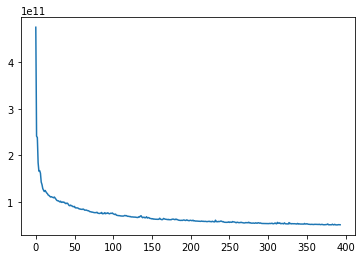

In [38]:
def SGD_draw_cost(SGD_costs):
  iter = np.arange(0, len(SGD_costs))
  plt.plot(iter, np.array(SGD_costs[:]))

SGD_draw_cost(SGD_costs)
print("Min cost: ", np.sqrt(min(SGD_costs)), " with time(s)", t_SGD)

> # **Normal Equation (NE)**

* This strategy can directly find out vector theta

In [39]:
def normal_equation(X, y):
  theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
  return theta

t0_NE = timeit.default_timer()
NE_theta = normal_equation(X_train, y_train)
t1_NE = timeit.default_timer()
t_NE = t1_NE - t0_NE
print("Time(s) for NE: ", t_NE)

Time(s) for NE:  0.006538115000012112


> # **Genetic algorithm (GA)**

**1.Initialize chromosome**: each chromosome represents for a theta vector




In [40]:
# random initalize chromosome or mutation process later
def generate_random_value(bound = 100):
  return (random.random()-0.5)*bound


# create chromosome
def create_chromosome():
  global chromosome_size
  return [generate_random_value() for _ in range(chromosome_size)]

**2.Compute fitness**: aims to evaluation the fitness of chromosome in population 

In [41]:
# cost funtion of vector theta (chromosome)
def compute_cost(chromosome):
  global X_train, y_train
  loss = metrics.mean_absolute_error(X_train.dot(chromosome), y_train)
  return loss

# evaluation 
def compute_fitness(chromosome):
  loss = compute_cost(chromosome)
  fitness = 1/(loss+1)
  return fitness

**3.Crossover process**: exchange first gene (intercept) & 1 gene fragment between 2 chromosome

In [42]:
def crossover(chromosome1, chromosome2, crossover_rate = 0.8):
  global chromosome_size
  chromosome1_new = chromosome1.copy()
  chromosome2_new = chromosome2.copy()
  
  i = random.randint(1, chromosome_size-1)
  if random.random() < crossover_rate:
    chromosome1_new[0] = chromosome2[0]   #exchange 1st gene
    chromosome2_new[0] = chromosome1[0]

    chromosome1_new[i:] = chromosome2[i:]  #exchange 1 gene fragment
    chromosome2_new[i:] = chromosome1[i:]  
              
  return chromosome1_new, chromosome2_new

**4.Mutation process**: make mutation for the population

In [43]:
def mutate(chromosome, mutation_rate = 0.05):

  chromosome_size = len(chromosome)
  chromosome_m = chromosome.copy()
  
  for i in range(chromosome_size):
    if random.random() < mutation_rate:
      chromosome_m[i] = chromosome_m[i]  * (1 + 0.1 * generate_random_value())
      
  return chromosome_m

**5.Selection**: choose random a "not bad" chromosome

In [44]:
def selection(sorted_old_population):
  global population_size    
  index1 = random.randint(0, population_size - 1)    
  while True:
    index2 = random.randint(0, population_size - 1)    
    if (index2 != index1):
        break
          
  chromosome_s = sorted_old_population[index1]
  if index2 > index1:
    chromosome_s = sorted_old_population[index2]
  
  return chromosome_s

**6.Create population**: with some of the best chromosomes (elitism) of the old population 

In [45]:
def create_new_population(old_population, elitism=5, gen=1):
  global GA_cost_history, population_size

  sorted_population = sorted(old_population, key=compute_fitness)
    
  new_population = []
  
  if gen%50 == 0:
    GA_cost_history.append(compute_cost(sorted_population[-1]))
    # print(compute_cost(sorted_population[-1]))

  while len(new_population) < population_size-elitism:
    # selection
    chromosome_s1 = selection(sorted_population)
    chromosome_s2 = selection(sorted_population) # may duplicate
    
    # crossover
    chromosome_c1, chromosome_c2 = crossover(chromosome_s1, chromosome_s2)
    
    # mutation
    chromosome_m1 = mutate(chromosome_c1)
    chromosome_m2 = mutate(chromosome_c2)
    
    new_population.append(chromosome_m1)
    new_population.append(chromosome_m2)            
  
  for chromo in sorted_population[population_size-elitism:]:  # keep the elitism
    new_population.append(chromo.copy())
    
  return new_population

**7.Initilize population & evolutionary process**

In [46]:
def GA(X, y):
  global GA_cost_history, chromosome_size, population_size
  chromosome_size = X.shape[1]                
  population_size = 500
  n_generations = 5000 
  GA_cost_history = []

  population = [create_chromosome() for _ in range(population_size)]
  for i in range(n_generations):
      population = create_new_population(population, 2, gen = i)

      # stop evolutionary process when population's evolution is inconsiderable
      if len(GA_cost_history) > 15:
        if GA_cost_history[-10] - GA_cost_history[-1] < 100:   
          break
          
  GA_theta = np.array(population[-1])
  return [GA_theta, GA_cost_history]


t0_GA = timeit.default_timer()
[GA_theta, GA_costs] = GA(X_train, y_train)
t1_GA = timeit.default_timer()
t_GA = t1_GA - t0_GA


**8.Visualize cost**

Min cost:  148286.4488732445  with time 1049.8706280119998


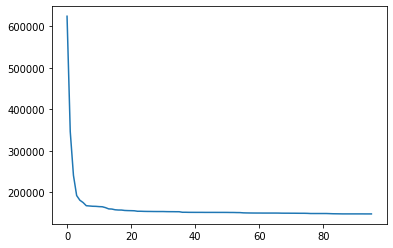

In [47]:
def GA_draw_cost(GA_costs):
  iter = np.arange(0, len(GA_costs))
  plt.plot(iter, np.array(GA_costs[:]))

GA_draw_cost(GA_costs)
print("Min cost: ", GA_costs[-1], ' with time', t_GA)

> # **Analysis on Validation set**

**1.Draw Learning Curves**: increment size of training set and fit the validation set

* **Calculate metrics for learning curves**

In [48]:
def learning_curves(X_train, y_train, X_val, y_val):

  SGD_train_cost, SGD_val_cost = [], []
  NE_train_cost, NE_val_cost = [], []
  GA_train_cost, GA_val_cost = [], []

  ratio = [1/X_train.shape[0], 0.1, 0.3, 0.6, 0.99]
  steps = [int(a*X_train.shape[0]) for a in ratio]

  t0 = timeit.default_timer()
  for i in steps:
    theta1 = SGD(X_train[:i], y_train[:i])[0]
    y_train_pred1= X_train[:i].dot(theta1)
    y_val_pred1 = X_val.dot(theta1)

    SGD_train_cost.append(np.sqrt(metrics.mean_squared_error(y_train[:i], y_train_pred1)))
    SGD_val_cost.append(np.sqrt(metrics.mean_squared_error(y_val, y_val_pred1)))

  t1 = timeit.default_timer()
  t10 = t1 - t0
  print("Time(s) for SGD: ", t10)

  for i in steps:
    theta2 = normal_equation(X_train[:i], y_train[:i])
    y_train_pred2= X_train[:i].dot(theta2)
    y_val_pred2 = X_val.dot(theta2)
    
    NE_train_cost.append(np.sqrt(metrics.mean_squared_error(y_train[:i], y_train_pred2)))
    NE_val_cost.append(np.sqrt(metrics.mean_squared_error(y_val, y_val_pred2)))

  t2 = timeit.default_timer()
  t21 = t2 - t1
  print("Time(s) for NE: ", t21)

  for i in steps:
    theta3 = GA(X_train[:i], y_train[:i])[0]
    y_train_pred3 = X_train[:i].dot(theta3)
    y_val_pred3 = X_val.dot(theta3)

    GA_train_cost.append(metrics.mean_absolute_error(y_train[:i], y_train_pred3))
    GA_val_cost.append(metrics.mean_absolute_error(y_val, y_val_pred3))
  
  t3 = timeit.default_timer()
  t32 = t3 - t2
  print("Time(s) for GA: ", t32)
  return [SGD_train_cost, SGD_val_cost, NE_train_cost, NE_val_cost, GA_train_cost, GA_val_cost]

[SGD_train_cost, SGD_val_cost, NE_train_cost, NE_val_cost, GA_train_cost, GA_val_cost] = learning_curves(X_train, y_train, X_val, y_val)

Time(s) for SGD:  63.93887482499986
Time(s) for NE:  0.018586606000098982
Time(s) for GA:  3658.159890782


* **Plot learning curves**

In [49]:
def plot_learning_curves(train_cost, val_cost):
  plt.plot(train_cost, "r", linewidth=2, label="train cost")   #red
  plt.plot(val_cost, "b", linewidth=3, label="val cost")       #blue
  plt.legend()


**SGD**



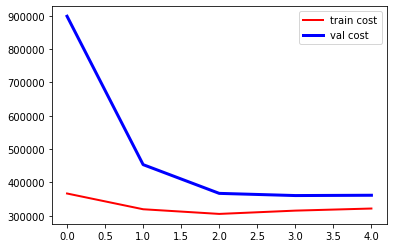

In [50]:
plot_learning_curves(SGD_train_cost, SGD_val_cost)

**NE**

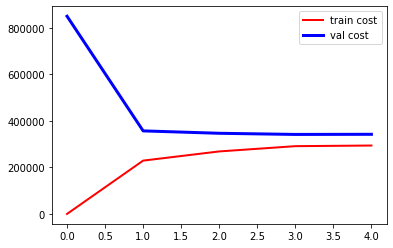

In [51]:
plot_learning_curves(NE_train_cost, NE_val_cost)

**GA**

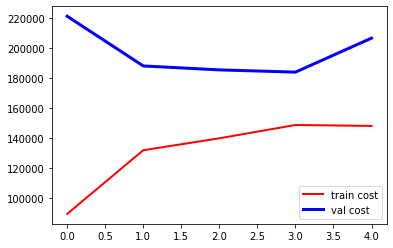

In [52]:
plot_learning_curves(GA_train_cost, GA_val_cost)

**2.Prediction comparition**

In [53]:
def compare(X, y, SGD_theta, NE_theta, GA_theta):

  SGD_pred = X.dot(SGD_theta)
  NE_pred = X.dot(NE_theta)
  GA_pred = X.dot(GA_theta).reshape(-1,1)

  return [SGD_pred, NE_pred, GA_pred]
  
[SGD_val_pred, NE_val_pred, GA_val_pred] = compare(X_val, y_val, SGD_theta, NE_theta, GA_theta)

df = pd.DataFrame(data=np.array([y_val[:,0], SGD_val_pred[:,0], abs(SGD_val_pred - y_val)[:,0], NE_val_pred[:,0], abs(NE_val_pred - y_val)[:,0],
                                 GA_val_pred[:,0], abs(GA_val_pred - y_val)[:,0]]).T,
             columns=["Real", "SGD predict","SGD difference", "NE predict","NE difference", "GA predict", "GA difference"])


# print out first ten predicted values
df.head(10)

,Real,SGD predict,SGD difference,NE predict,NE difference,GA predict,GA difference
0,130000.0,-1.944988e+05,324498.837005,-224148.836049,354148.836049,-191793.240766,321793.240766
1,640000.0,4.108692e+05,229130.820429,362141.031004,277858.968996,418017.143998,221982.856002
2,445000.0,8.016664e+05,356666.415605,602930.537153,157930.537153,913290.441779,468290.441779
3,120000.0,-5.425800e+04,174257.996501,-128241.097729,248241.097729,-120549.256277,240549.256277
4,121000.0,-5.162075e+04,172620.747800,48758.070057,72241.929943,17434.376094,103565.623906
5,550000.0,1.066138e+05,443386.227712,164932.925434,385067.074566,229330.751039,320669.248961
6,503000.0,8.382462e+05,335246.230691,744443.337302,241443.337302,754870.357767,251870.357767
7,85000.0,-3.439559e+05,428955.866898,-295475.282774,380475.282774,-231971.978846,316971.978846
8,1150000.0,1.144271e+06,5729.448750,971240.423378,178759.576622,868866.036817,281133.963183
9,360000.0,3.352145e+05,24785.475723,290778.936752,69221.063248,289741.281756,70258.718244


**3.Plot the predicted values**

In [54]:
def plot(X, y, theta):
  y_predict = X.dot(theta)
  v_size = len(X)
  
  zip1 = list(zip(y, y_predict))
  zip1 = sorted(zip1, key = lambda k: k[0])

  #size
  y_real = np.array(zip1)[:,0]
  y_predict = np.array(zip1)[:, 1]

  #
  fig, ax = plt.subplots(figsize = (50, 10))
  plt.plot(y_real, c = 'green')
  plt.plot(y_predict, c = 'blue')


  ax.spines['top'].set_color('none')
  ax.spines['right'].set_color('none')

  ax.xaxis.set_ticks_position('bottom')
  ax.spines['bottom'].set_position(('data',0))

  ax.yaxis.set_ticks_position('left')
  ax.spines['left'].set_position(('data', 0))


* **SGD algorithm**

Predicted values with SGD algorithm: 


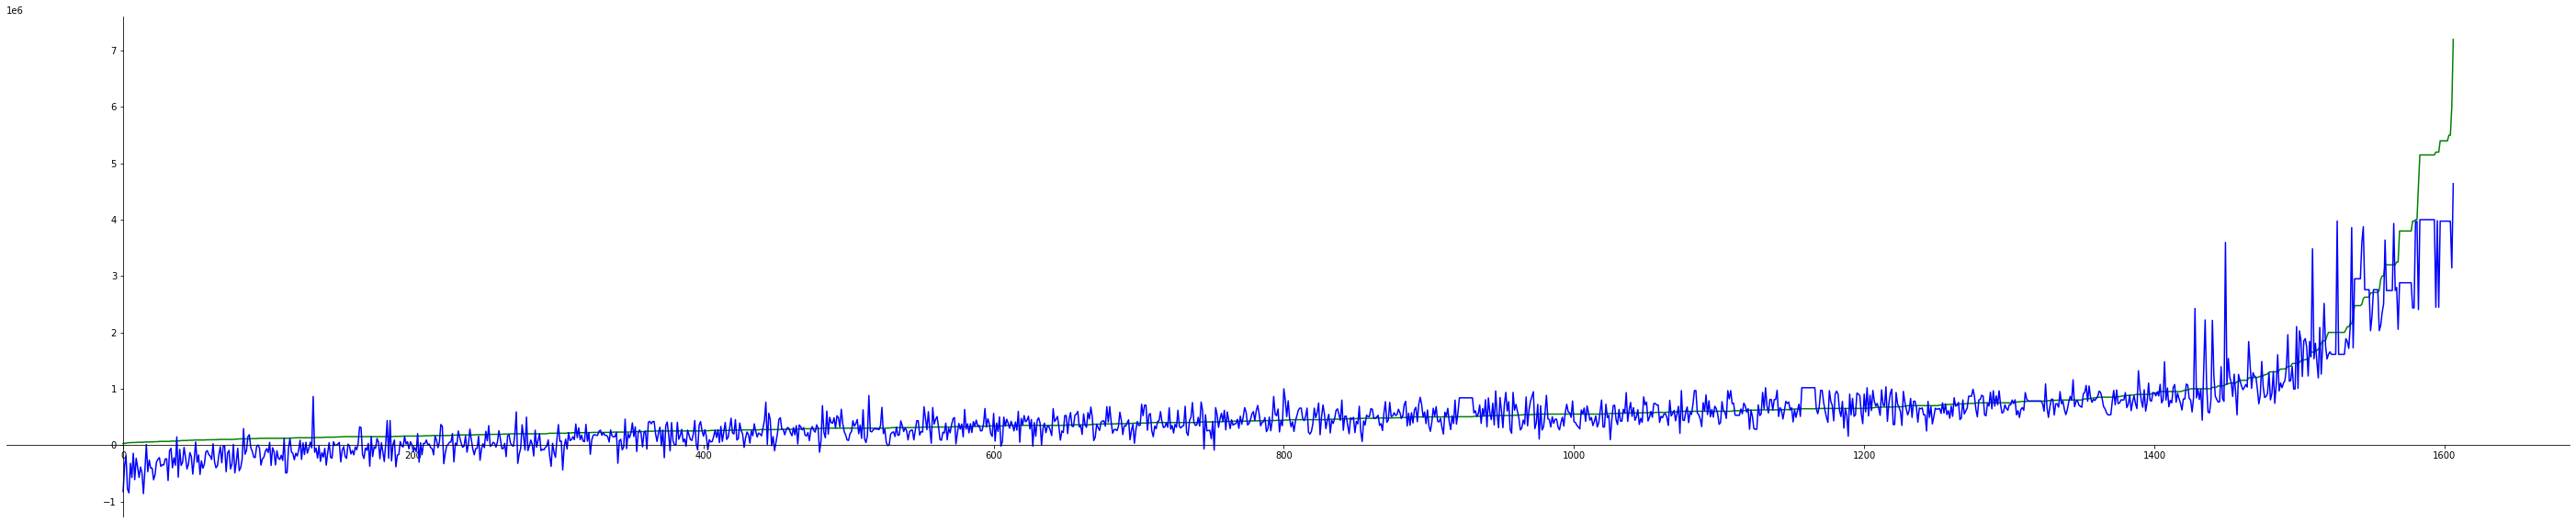

In [55]:
print("Predicted values with SGD algorithm: ")
plot(X_val, y_val, SGD_theta)

* **NE algorithm**

Predicted values with NE algorithm: 


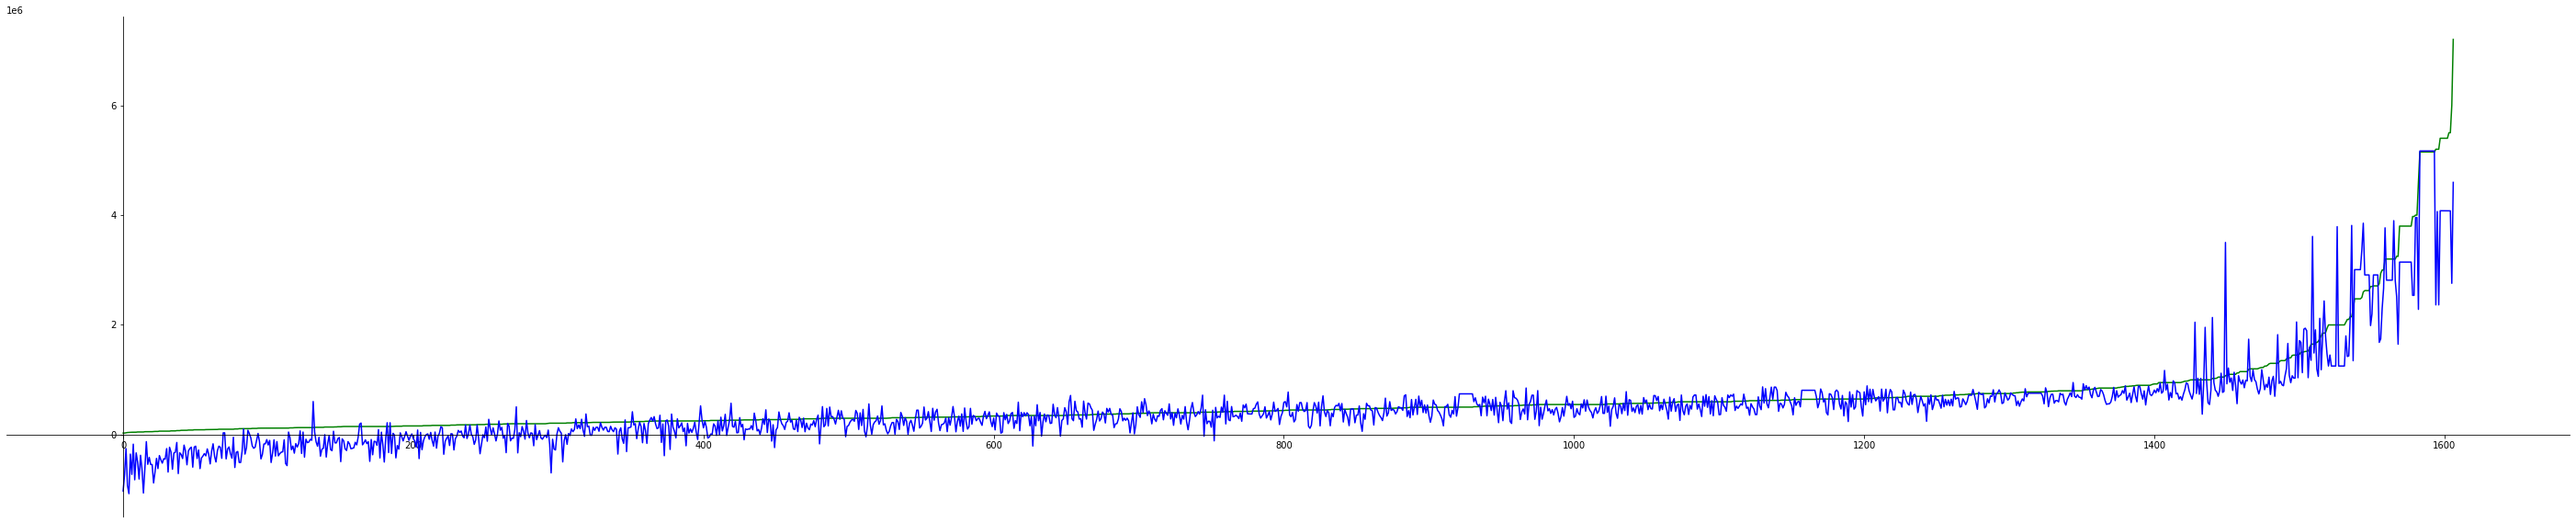

In [56]:
print("Predicted values with NE algorithm: ")
plot(X_val, y_val, NE_theta)

* **GA algorithm**

Predicted values with GA algorithm: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


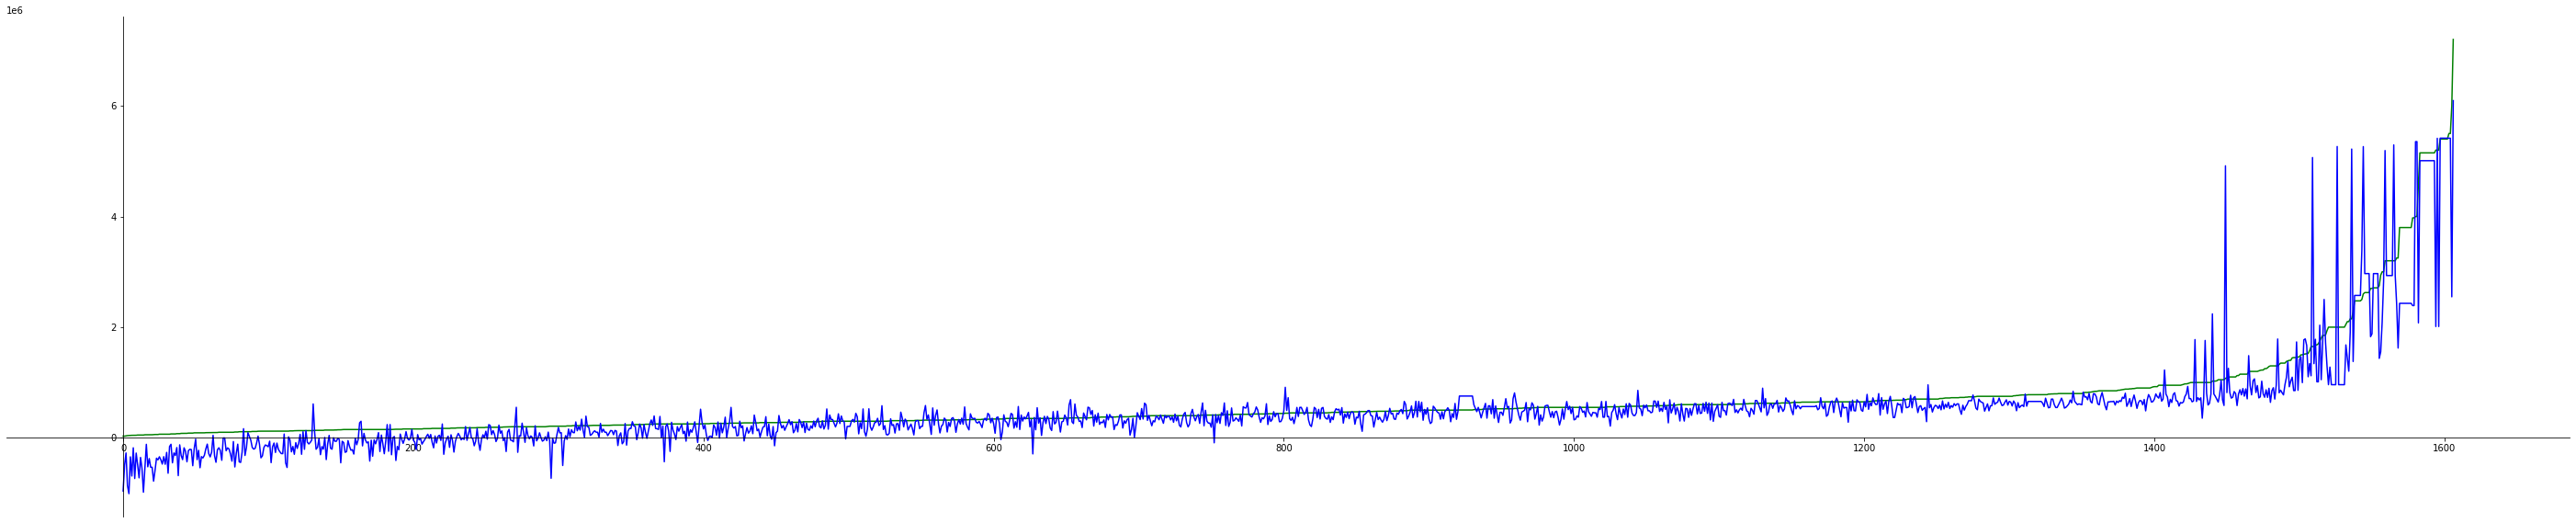

In [57]:
print("Predicted values with GA algorithm: ")
plot(X_val, y_val, GA_theta)

**3.Model metrics evaluation**

In [58]:
def model_evaluation(X, y):
  global SGD_theta, NE_theta, GA_theta

  [SGD_pred, NE_pred, GA_pred] = compare(X, y, SGD_theta, NE_theta, GA_theta)


  print("MAE SGD: ", metrics.mean_absolute_error(y, SGD_pred))
  print("MAE NE: ", metrics.mean_absolute_error(y, NE_pred))
  print("MAE GA: ", metrics.mean_absolute_error(y, GA_pred))
  print()

  print("RMSE SGD: ", np.sqrt(metrics.mean_squared_error(y, SGD_pred)))
  print("RMSE NE: ", np.sqrt(metrics.mean_squared_error(y, NE_pred)))
  print("RMSE GA: ", np.sqrt(metrics.mean_squared_error(y, GA_pred)))
  print()

  print("R2 SGD: ", metrics.r2_score(y, SGD_pred))
  print("R2 NE: ", metrics.r2_score(y, NE_pred))
  print("R2 GA: ", metrics.r2_score(y, GA_pred))
  print()
  


* **On train set**

In [59]:
print("In train set:")
model_evaluation(X_train, y_train)

In train set:
MAE SGD:  186056.78326544797
MAE NE:  154717.79142197262
MAE GA:  148286.4488732445

RMSE SGD:  318423.7953093393
RMSE NE:  293958.44213580084
RMSE GA:  352631.5050896663

R2 SGD:  0.8210879702421316
R2 NE:  0.8475243869356663
R2 GA:  0.7805827662251097



* **On validation set**

In [60]:
print("In validation set:")
model_evaluation(X_val, y_val)

In validation set:
MAE SGD:  214402.69382773814
MAE NE:  214402.94577636448
MAE GA:  212545.2673820121

RMSE SGD:  342806.10929329274
RMSE NE:  341821.66141691396
RMSE GA:  379438.7912738111

R2 SGD:  0.8226494345001669
R2 NE:  0.8236665791275697
R2 GA:  0.7827204126443859



> # Test

* **1. Test metrics evaluation**

In [61]:
print("In test set:")
model_evaluation(X_test, y_test)

In test set:
MAE SGD:  206274.864891407
MAE NE:  200062.75277937838
MAE GA:  184972.64815596546

RMSE SGD:  355561.9492703313
RMSE NE:  353563.14789021236
RMSE GA:  384062.1988194827

R2 SGD:  0.8308829189793057
R2 NE:  0.8327789673558434
R2 GA:  0.8026850257361023



* **2.Print predicted value**

In [62]:
[SGD_test_pred, NE_test_pred, GA_test_pred] = compare(X_test, y_test, SGD_theta, NE_theta, GA_theta)


df2 = pd.DataFrame(data=np.array([y_val[:,0], SGD_test_pred[:,0], abs(SGD_test_pred - y_val)[:,0], NE_test_pred[:,0],
                                  abs(NE_test_pred - y_val)[:,0],GA_test_pred[:,0], abs(GA_test_pred - y_val)[:,0]]).T,
             columns=["Real", "SGD predict","SGD difference", "NE predict","NE difference", "GA predict", "GA difference"])

# print out first ten predicted values
df2.head(10)

,Real,SGD predict,SGD difference,NE predict,NE difference,GA predict,GA difference
0,130000.0,7.243700e+05,594370.035961,471772.197414,341772.197414,384753.280795,254753.280795
1,640000.0,8.666442e+05,226644.246018,726571.754032,86571.754032,671096.929687,31096.929687
2,445000.0,5.678156e+05,122815.629378,673762.164392,228762.164392,644953.422351,199953.422351
3,120000.0,7.380542e+05,618054.187908,765643.857368,645643.857368,767921.174556,647921.174556
4,121000.0,7.715327e+05,650532.689423,762482.269915,641482.269915,711409.056185,590409.056185
5,550000.0,8.304992e+05,280499.246342,890365.847950,340365.847950,813722.944545,263722.944545
6,503000.0,1.068940e+04,492310.599173,-87526.792896,590526.792896,-62421.619116,565421.619116
7,85000.0,4.997612e+05,414761.183414,509900.652211,424900.652211,422617.158924,337617.158924
8,1150000.0,6.481856e+05,501814.408681,604156.608196,545843.391804,618905.841965,531094.158035
9,360000.0,1.055102e+06,695102.108033,826739.394615,466739.394615,707893.914477,347893.914477


* **3.Plot predicted valie**

* **SGD algorithm**


Predicted values with SGD algorithm: 


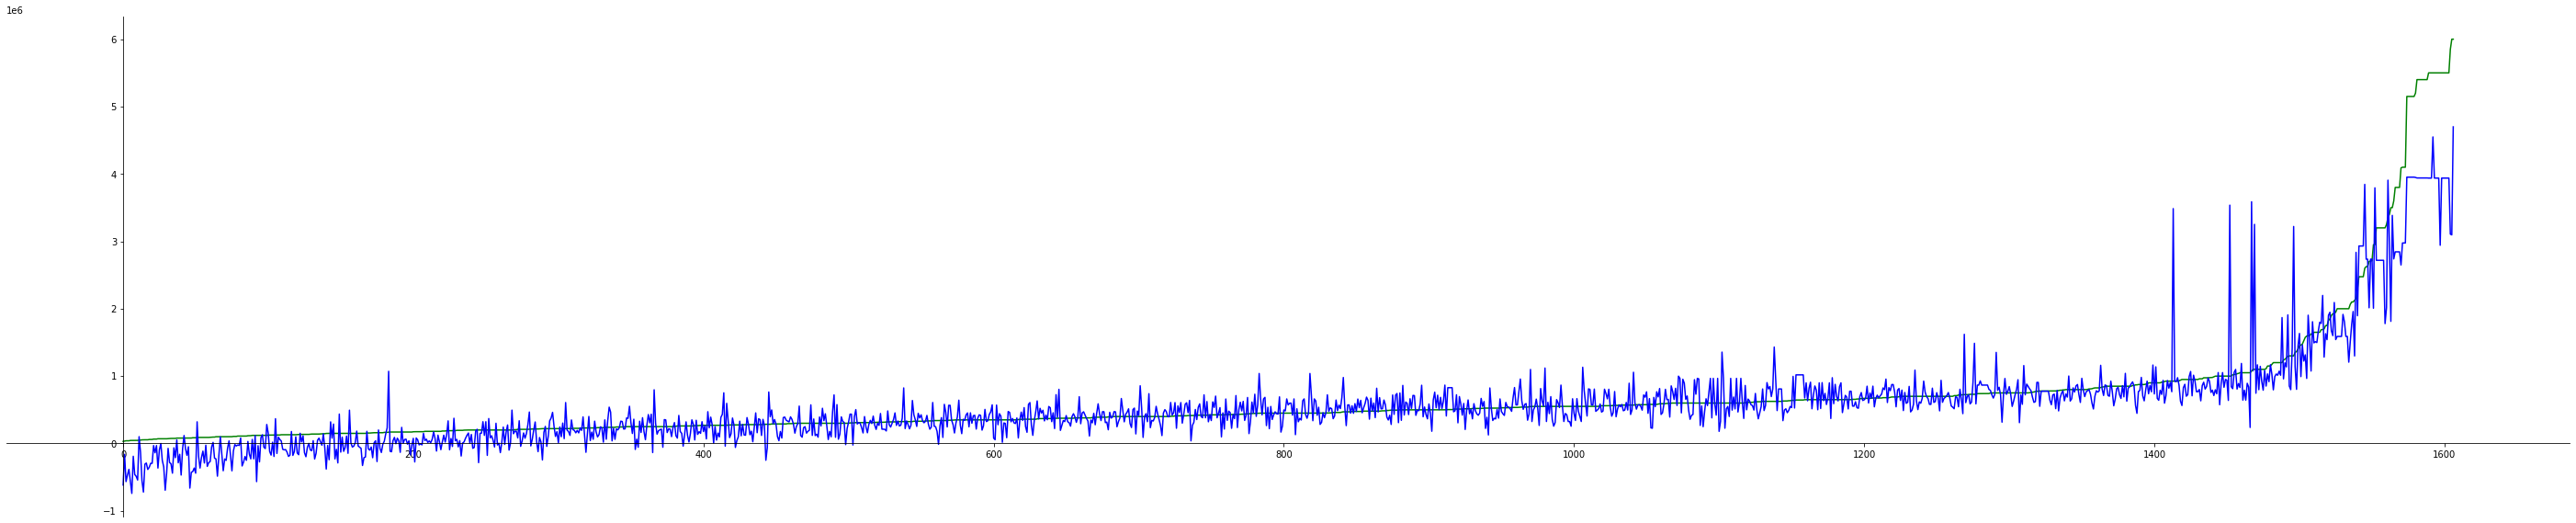

In [63]:
print("Predicted values with SGD algorithm: ")
plot(X_test, y_test, SGD_theta)

* **NE algorithm**


Predicted values with SGD algorithm: 


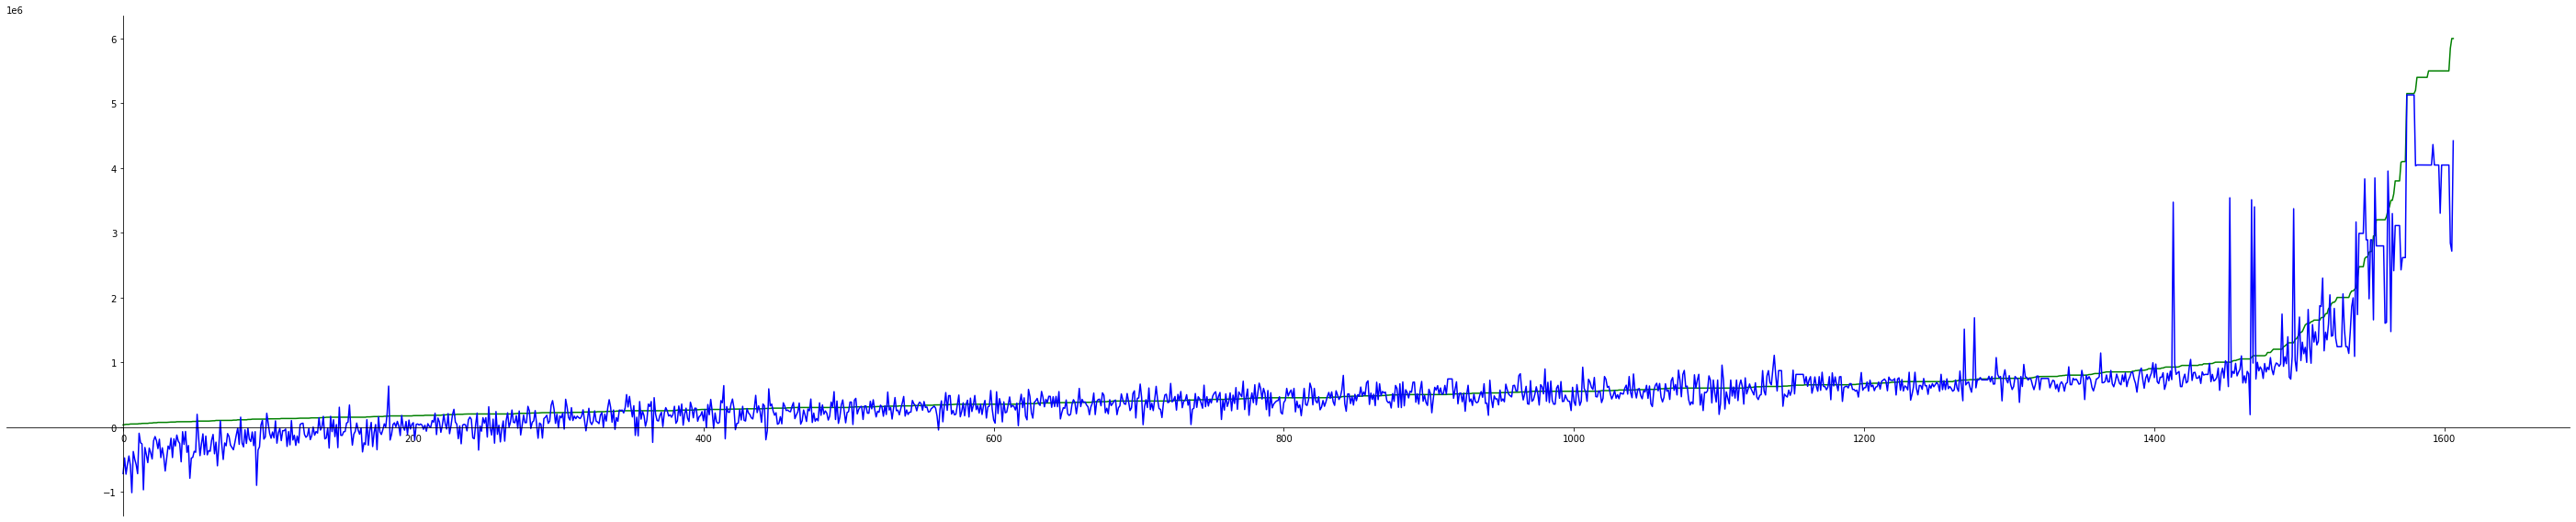

In [64]:
print("Predicted values with SGD algorithm: ")
plot(X_test, y_test, NE_theta)

* **GA algorithm**


Predicted values with SGD algorithm: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


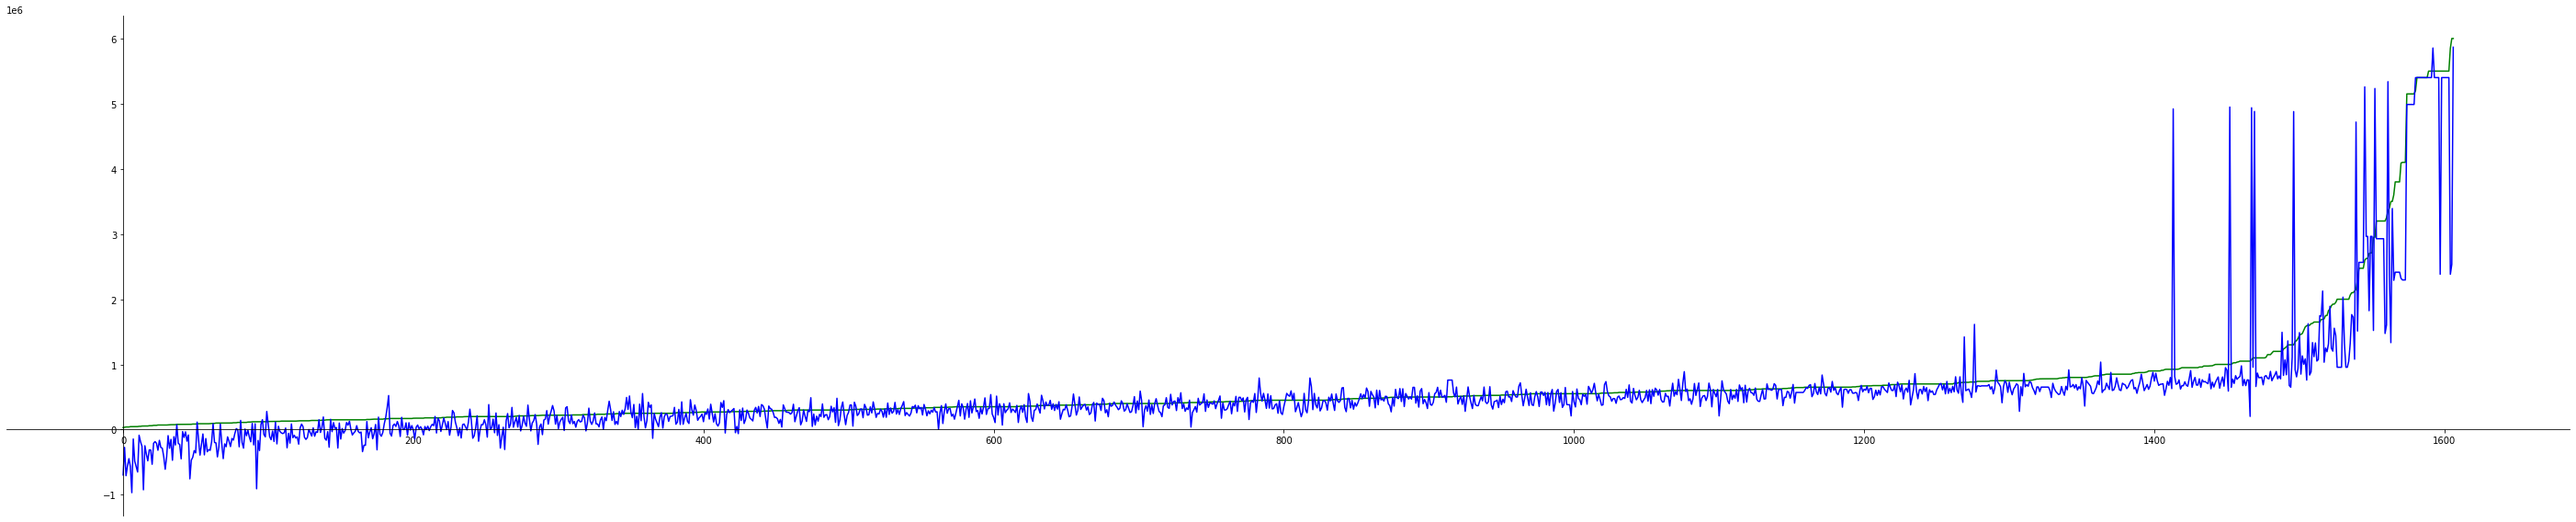

In [65]:
print("Predicted values with SGD algorithm: ")
plot(X_test, y_test, GA_theta)